In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
from shapely.strtree import STRtree
import networkx as nx
from scipy.spatial import cKDTree
import os

In [2]:
# =============================================================================
# 1. LOAD DATA
# =============================================================================
clip_dir = "D:\\Github\\case_study_flood\\DATASETS\\CLIP"

adm4_ncr = gpd.read_file(f"{clip_dir}/adm4_ncr.shp")
flood_ncr = gpd.read_file(f"{clip_dir}/flood_ncr.shp")
health_ncr = gpd.read_file(f"{clip_dir}/health_ncr.shp")

# Load road layers
road_layers_ncr = {}
for file in os.listdir(clip_dir):
    if file.startswith("road_") and file.endswith(".shp"):
        key = file.replace(".shp", "")
        road_layers_ncr[key] = gpd.read_file(os.path.join(clip_dir, file))

# Reproject to UTM
proj_crs = "EPSG:32651"
adm4_ncr = adm4_ncr.to_crs(proj_crs)
flood_ncr = flood_ncr.to_crs(proj_crs)
health_ncr = health_ncr.to_crs(proj_crs)

for key in road_layers_ncr:
    road_layers_ncr[key] = road_layers_ncr[key].to_crs(proj_crs)

In [3]:
# =============================================================================
# 2. COMBINE ALL ROAD LAYERS
# =============================================================================
# Combine all road layers into one GeoDataFrame
roads_list = []
for key, gdf in road_layers_ncr.items():
    gdf_copy = gdf.copy()
    gdf_copy['road_type'] = key  # Keep track of road type
    roads_list.append(gdf_copy)

roads_combined = pd.concat(roads_list, ignore_index=True)

# Filter only LineString geometries
roads_combined = roads_combined[roads_combined.geometry.type == 'LineString']

print(f"Total road segments: {len(roads_combined)}")

Total road segments: 623


In [4]:
# =============================================================================
# 3. ASSIGN SPEEDS BY ROAD TYPE (km/h)
# =============================================================================
speed_mapping = {
    'road_motorway': 80,
    'road_trunk': 60,
    'road_primary': 50,
    'road_secondary': 40,
    'road_tertiary': 30,
    'road_residential': 20,
    'road_service': 15,
    'road_track': 10,
    'road_path': 5
}

# Default speed for unknown types
roads_combined['speed_kmh'] = roads_combined['road_type'].map(speed_mapping).fillna(20)

# Calculate travel time in minutes
roads_combined['length_m'] = roads_combined.geometry.length
roads_combined['time_min'] = (roads_combined['length_m'] / 1000) / roads_combined['speed_kmh'] * 60

In [5]:
# =============================================================================
# 4. REMOVE FLOODED ROAD SEGMENTS (OPTIMIZED WITH SPATIAL INDEX)
# =============================================================================
# Dissolve and simplify flood polygons
print("Dissolving flood polygons...")
flood_dissolved = flood_ncr.dissolve()
flood_geom = unary_union(flood_dissolved.geometry)
flood_geom = flood_geom.simplify(tolerance=50)  # Simplify for faster intersection

print("Identifying flooded road segments...")

# Build spatial index for roads (FAST!)
tree = STRtree(roads_combined.geometry)
flooded_indices = tree.query(flood_geom, predicate='intersects')

# Create boolean mask
is_flooded = np.zeros(len(roads_combined), dtype=bool)
is_flooded[flooded_indices] = True

# Split into flooded and non-flooded
roads_flooded = roads_combined[is_flooded].copy()
roads_no_flood = roads_combined[~is_flooded].copy()

print(f"Roads before flood: {len(roads_combined)}")
print(f"Flooded segments: {len(roads_flooded)}")
print(f"Roads after flood: {len(roads_no_flood)}")

Dissolving flood polygons...
Identifying flooded road segments...
Roads before flood: 623
Flooded segments: 553
Roads after flood: 70


In [6]:
# =============================================================================
# 5. BUILD NETWORK GRAPHS WITH GRID SNAPPING (IMPROVED CONNECTIVITY)
# =============================================================================
def build_network_graph_snapped(roads_gdf, grid_size=10):
    """
    Build NetworkX graph from road segments with grid-based snapping
    
    Args:
        roads_gdf: GeoDataFrame of road segments
        grid_size: Grid cell size in meters for snapping endpoints
    """
    G = nx.Graph()
    
    def snap_to_grid(coord, grid_size):
        """Snap coordinate to grid"""
        return (round(coord[0] / grid_size) * grid_size,
                round(coord[1] / grid_size) * grid_size)
    
    for idx, row in roads_gdf.iterrows():
        geom = row.geometry
        if geom.geom_type == 'LineString':
            coords = list(geom.coords)
            
            # Snap endpoints to grid for better connectivity
            start = snap_to_grid(coords[0], grid_size)
            end = snap_to_grid(coords[-1], grid_size)
            
            # Add edge with travel time as weight (avoid self-loops)
            if start != end:
                # If edge already exists, keep the one with shorter time
                if G.has_edge(start, end):
                    existing_weight = G[start][end]['weight']
                    if row['time_min'] < existing_weight:
                        G[start][end]['weight'] = row['time_min']
                        G[start][end]['length'] = row['length_m']
                else:
                    G.add_edge(start, end, weight=row['time_min'], length=row['length_m'])
    
    return G

print("Building network graphs with finer grid...")
G_before = build_network_graph_snapped(roads_combined, grid_size=10)
G_after = build_network_graph_snapped(roads_no_flood, grid_size=10)

print(f"Network before: {G_before.number_of_nodes()} nodes, {G_before.number_of_edges()} edges")
print(f"Network after: {G_after.number_of_nodes()} nodes, {G_after.number_of_edges()} edges")

# Check connectivity
n_components_before = nx.number_connected_components(G_before)
n_components_after = nx.number_connected_components(G_after)
print(f"Connected components before: {n_components_before}")
print(f"Connected components after: {n_components_after}")

Building network graphs with finer grid...
Network before: 590 nodes, 568 edges
Network after: 68 nodes, 65 edges
Connected components before: 89
Connected components after: 8


In [7]:
# =============================================================================
# 6. COMPUTE TRAVEL TIMES TO NEAREST HOSPITAL
# =============================================================================
# Get barangay centroids
adm4_ncr['centroid'] = adm4_ncr.geometry.centroid
barangay_points = [(pt.x, pt.y) for pt in adm4_ncr['centroid']]

# Get hospital locations
hospital_points = [(pt.x, pt.y) for pt in health_ncr.geometry]

def nearest_node(point, graph_nodes):
    """Find nearest graph node to a point"""
    nodes_array = np.array(list(graph_nodes))
    tree = cKDTree(nodes_array)
    dist, idx = tree.query(point)
    return tuple(nodes_array[idx])

def compute_travel_times(barangay_pts, hospital_pts, graph):
    """Compute minimum travel time from each barangay to nearest hospital"""
    travel_times = []
    
    # Get largest connected component for more reliable routing
    if nx.number_connected_components(graph) > 1:
        largest_cc = max(nx.connected_components(graph), key=len)
        graph_main = graph.subgraph(largest_cc).copy()
        print(f"  Using largest component with {len(graph_main.nodes())} nodes")
    else:
        graph_main = graph
    
    for b_pt in barangay_pts:
        # Find nearest node in graph to barangay centroid
        b_node = nearest_node(b_pt, graph_main.nodes())
        
        # ADD DISTANCE PENALTY from barangay to nearest node
        nodes_array = np.array(list(graph_main.nodes()))
        tree = cKDTree(nodes_array)
        dist_to_node, _ = tree.query(b_pt)
        access_penalty = dist_to_node / 1000 / 20 * 60  # Assume 20 km/h walking speed
        
        min_time = np.inf
        
        for h_pt in hospital_pts:
            # Find nearest node to hospital
            h_node = nearest_node(h_pt, graph_main.nodes())
            
            # ADD DISTANCE PENALTY from hospital to nearest node
            dist_to_hospital, _ = tree.query(h_pt)
            egress_penalty = dist_to_hospital / 1000 / 20 * 60
            
            try:
                # Compute shortest path
                path_time = nx.shortest_path_length(graph_main, b_node, h_node, weight='weight')
                total_time = access_penalty + path_time + egress_penalty
                min_time = min(min_time, total_time)
            except nx.NetworkXNoPath:
                # No path exists
                continue
        
        # If no path found, set to very high value
        if min_time == np.inf:
            min_time = 999
        
        travel_times.append(min_time)
    
    return travel_times

print("Computing travel times before flood...")
times_before = compute_travel_times(barangay_points, hospital_points, G_before)

print("Computing travel times after flood...")
times_after = compute_travel_times(barangay_points, hospital_points, G_after)

Computing travel times before flood...
  Using largest component with 244 nodes
Computing travel times after flood...
  Using largest component with 39 nodes


In [8]:
# =============================================================================
# 7. COMPUTE DELTA TRAVEL TIME
# =============================================================================
adm4_ncr['time_before'] = times_before
adm4_ncr['time_after'] = times_after
adm4_ncr['delta_time'] = adm4_ncr['time_after'] - adm4_ncr['time_before']

# Handle cases where no path exists
adm4_ncr.loc[adm4_ncr['time_after'] >= 999, 'delta_time'] = 999

In [9]:
# =============================================================================
# 8. TOP 10 WORST AFFECTED BARANGAYS
# =============================================================================
top10_affected = adm4_ncr[['ADM4_EN', 'ADM3_EN', 'time_before', 'time_after', 'delta_time']]\
    .sort_values('delta_time', ascending=False).head(10)

top10_affected = top10_affected.rename(columns={
    'ADM4_EN': 'Barangay',
    'ADM3_EN': 'Municipality',
    'time_before': 'Before (min)',
    'time_after': 'After (min)',
    'delta_time': 'Δ Time (min)'
})

# Round values
top10_affected['Before (min)'] = top10_affected['Before (min)'].round(1)
top10_affected['After (min)'] = top10_affected['After (min)'].round(1)
top10_affected['Δ Time (min)'] = top10_affected['Δ Time (min)'].round(1)

print("\nTop 10 Worst Affected Barangays:")
print(top10_affected)

# Save table
top10_affected.to_csv("top10_network_disruption.csv", index=False)


Top 10 Worst Affected Barangays:
           Barangay       Municipality  Before (min)  After (min)  \
32     Pamplona Uno  City of Las Piñas          11.4         66.4   
33           Zapote  City of Las Piñas           9.3         64.3   
31     Pamplona Dos  City of Las Piñas          13.9         68.5   
34            Ilaya  City of Las Piñas           4.9         59.2   
2     Pamplona Tres  City of Las Piñas          11.3         65.4   
35  Pulang Lupa Dos  City of Las Piñas           8.4         62.4   
1         Talon Dos  City of Las Piñas          16.8         69.7   
37     San Dionisio  City of Parañaque           3.2         54.7   
36       Manuyo Dos  City of Las Piñas           8.4         59.3   
0      Talon Singko  City of Las Piñas          23.3         72.4   

    Δ Time (min)  
32          55.0  
33          55.0  
31          54.6  
34          54.4  
2           54.1  
35          54.0  
1           52.8  
37          51.5  
36          50.9  
0           49.1

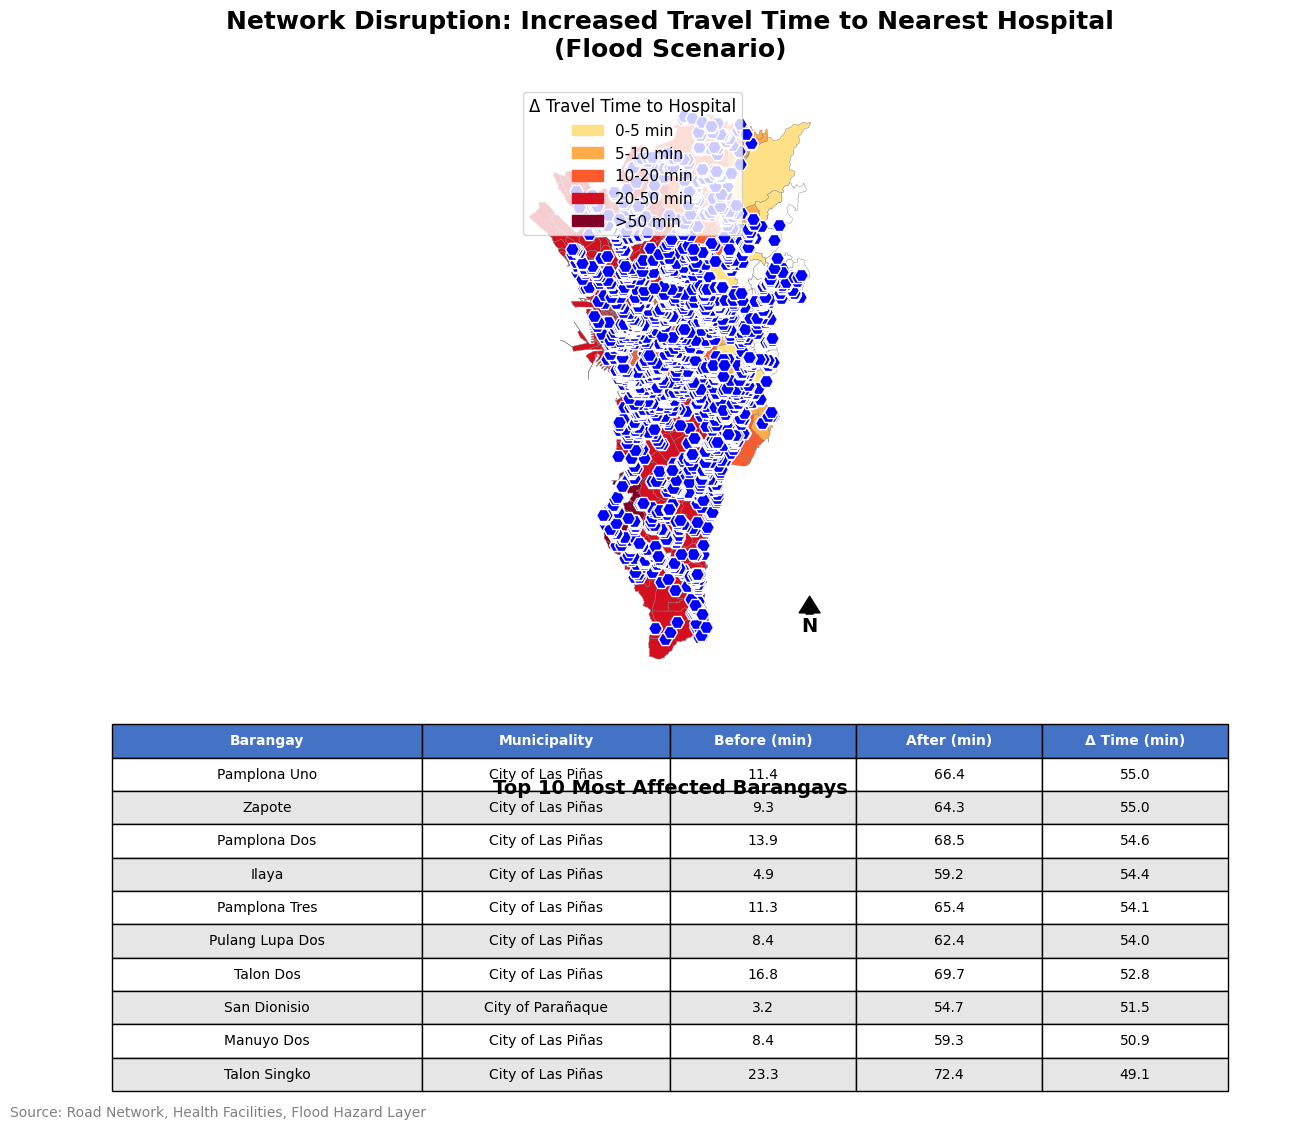


✓ Task 6 complete!
✓ Map saved: NCR_Network_Disruption_Map.png
✓ Table saved: top10_network_disruption.csv


In [10]:
# =============================================================================
# 9. CHOROPLETH MAP WITH INSET TABLE
# =============================================================================
# Classification for delta time
bins = [0, 5, 10, 20, 50, 999]
labels = ['0-5 min', '5-10 min', '10-20 min', '20-50 min', '>50 min']

adm4_ncr['delta_class'] = pd.cut(
    adm4_ncr['delta_time'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Create figure with main plot and table
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[2, 1], 
                      hspace=0.3, wspace=0.2)

# Main map
ax_map = fig.add_subplot(gs[0, :])

# Color map
cmap = plt.cm.YlOrRd
colors = {
    '0-5 min': cmap(0.2),
    '5-10 min': cmap(0.4),
    '10-20 min': cmap(0.6),
    '20-50 min': cmap(0.8),
    '>50 min': cmap(1.0)
}

# FIX: Convert categorical to string before mapping
adm4_ncr['delta_class_str'] = adm4_ncr['delta_class'].astype(str)
adm4_ncr['plot_color'] = adm4_ncr['delta_class_str'].map(colors)

# Handle NaN values (set to white)
adm4_ncr['plot_color'] = adm4_ncr['plot_color'].fillna('#FFFFFF')

# Plot choropleth
adm4_ncr.plot(
    ax=ax_map,
    color=adm4_ncr['plot_color'],
    edgecolor='gray',
    linewidth=0.3
)

# Plot hospitals
health_ncr.plot(ax=ax_map, marker='H', color='blue', markersize=100, 
                label='Hospitals', edgecolor='white', linewidth=1)

# Legend
legend_patches = [
    mpatches.Patch(color=colors[label], label=label) for label in labels
]
ax_map.legend(handles=legend_patches, title='Δ Travel Time to Hospital', 
              loc='upper left', fontsize=11, title_fontsize=12)

ax_map.set_title("Network Disruption: Increased Travel Time to Nearest Hospital\n(Flood Scenario)", 
                 fontsize=18, fontweight='bold', pad=20)
ax_map.set_axis_off()

# North arrow
x, y, arrow_length = 0.95, 0.15, 0.05
ax_map.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=14, 
                xycoords=ax_map.transAxes, fontweight='bold')

# Inset table
ax_table = fig.add_subplot(gs[1, :])
ax_table.axis('tight')
ax_table.axis('off')

table_data = top10_affected.values.tolist()
table_cols = top10_affected.columns.tolist()

table = ax_table.table(cellText=table_data, colLabels=table_cols,
                       cellLoc='center', loc='center',
                       colWidths=[0.25, 0.2, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(len(table_cols)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data) + 1):
    for j in range(len(table_cols)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')

ax_table.set_title("Top 10 Most Affected Barangays", 
                   fontsize=14, fontweight='bold', pad=10)

# Source
plt.figtext(0.1, 0.02, 'Source: Road Network, Health Facilities, Flood Hazard Layer', 
            fontsize=10, ha='left', color='gray')

# Save
plt.savefig("NCR_Network_Disruption_Map.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Task 6 complete!")
print(f"✓ Map saved: NCR_Network_Disruption_Map.png")
print(f"✓ Table saved: top10_network_disruption.csv")